# ASVspoof5 Train-Only Probe (Tuned) ? B -> C with Per-User Evaluation

Trains a tuned global probe (speaker-disjoint validation inside `B`) and reports per-user metrics for all `B` and `C` users.


In [1]:
import json
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torchaudio
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PROJECT_ROOT = Path("/home/SpeakerRec/BioVoice")
MANIFEST_PATH = PROJECT_ROOT / "redimnet" / "tcav" / "deepfakes" / "asvspoof5" / "asvspoof5_train_only_selected_utterances_plan.csv"
SUBSET_AUDIO_ROOT = PROJECT_ROOT / "data" / "datasets" / "asvspoof5_train_only_subset_audio"
EMBED_CACHE_DIR = PROJECT_ROOT / "data" / "embeddings" / "asvspoof5_train_only_abc"
EMBED_CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Tuning config (speaker-disjoint split inside group B)
VAL_SPEAKER_COUNT = 3      # from 15 B speakers -> 12 train, 3 val
TUNE_SEED = 42
C_GRID = [0.01, 0.1, 1.0, 10.0]
CLASS_WEIGHT_OPTIONS = [None, 'balanced']
THRESH_GRID = np.linspace(0.05, 0.95, 181)
FORCE_RECOMPUTE_EMBEDDINGS = False

print("DEVICE:", DEVICE)
print("MANIFEST_PATH:", MANIFEST_PATH)
print("SUBSET_AUDIO_ROOT:", SUBSET_AUDIO_ROOT)

OUT_DIR = PROJECT_ROOT / 'data' / 'models' / 'asvspoof5_train_only_probe_BC_per_user_tuned'
OUT_DIR.mkdir(parents=True, exist_ok=True)
CACHE_NPZ = EMBED_CACHE_DIR / 'embeddings_BC_global.npz'


DEVICE: cuda
MANIFEST_PATH: /home/SpeakerRec/BioVoice/redimnet/tcav/deepfakes/asvspoof5/asvspoof5_train_only_selected_utterances_plan.csv
SUBSET_AUDIO_ROOT: /home/SpeakerRec/BioVoice/data/datasets/asvspoof5_train_only_subset_audio


In [3]:
LABEL_MAP = {"bonafide": 0, "spoof": 1}


def build_audio_path(row, subset_root: Path) -> Path:
    return subset_root / str(row["group"]) / str(row["label"]) / f"{row['utt_id']}.flac"


def load_manifest(manifest_path: Path, subset_root: Path) -> pd.DataFrame:
    df = pd.read_csv(manifest_path).copy()
    req = {"group","speaker_id","utt_id","label","system_id"}
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"Manifest missing columns: {sorted(missing)}")
    df["label_str"] = df["label"].astype(str)
    df["label_id"] = df["label_str"].map(LABEL_MAP).astype(int)
    df["audio_path"] = df.apply(lambda r: str(build_audio_path(r, subset_root)), axis=1)
    df["audio_exists"] = df["audio_path"].map(lambda p: Path(p).exists())
    return df


def embed_with_redim(model, wav_path: str, device: str) -> np.ndarray:
    wav, sr = torchaudio.load(wav_path)
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, sr, 16000)
    if wav.shape[0] > 1:
        wav = wav[:1, :]
    wav = wav.to(device)
    with torch.no_grad():
        emb = model(wav)
    return emb.squeeze(0).detach().cpu().numpy().astype(np.float32)


def extract_embeddings_for_df(df_paths: pd.DataFrame, model, device: str, cache_npz: Path, force_recompute: bool=False):
    if cache_npz.exists() and not force_recompute:
        payload = np.load(cache_npz, allow_pickle=True)
        X = payload['X']
        utt_ids = payload['utt_ids'].astype(str)
        lut = pd.DataFrame({'utt_id': utt_ids, '_idx': np.arange(len(utt_ids))})
        m = df_paths[['utt_id']].merge(lut, on='utt_id', how='left', validate='one_to_one')
        if m['_idx'].isna().any():
            miss = m.loc[m['_idx'].isna(), 'utt_id'].tolist()[:10]
            raise RuntimeError(f"Embedding cache missing utt_ids, examples: {miss}")
        return X[m['_idx'].astype(int).to_numpy()]

    vecs, ids = [], []
    for rec in tqdm(df_paths.to_dict('records'), desc=f"Embedding {len(df_paths)}"):
        p = Path(rec['audio_path'])
        if not p.exists():
            raise FileNotFoundError(f"Missing audio: {p}")
        vecs.append(embed_with_redim(model, str(p), device))
        ids.append(str(rec['utt_id']))
    X = np.stack(vecs).astype(np.float32)
    np.savez_compressed(cache_npz, X=X, utt_ids=np.array(ids, dtype=object))
    return X


def split_B_speakers(df: pd.DataFrame, n_val_speakers=3, seed=42):
    b_speakers = sorted(df.loc[df['group'].eq('B'), 'speaker_id'].astype(str).unique().tolist())
    if len(b_speakers) <= n_val_speakers:
        raise ValueError(f"Not enough B speakers ({len(b_speakers)}) for val={n_val_speakers}")
    rng = np.random.default_rng(seed)
    shuffled = b_speakers.copy()
    rng.shuffle(shuffled)
    val = sorted(shuffled[:n_val_speakers])
    train = sorted(shuffled[n_val_speakers:])
    return train, val


def metrics_at_threshold(y_true, p1, thr):
    y_hat = (p1 >= thr).astype(int)
    cm = confusion_matrix(y_true, y_hat).tolist()
    out = {
        'threshold': float(thr),
        'accuracy': float(accuracy_score(y_true, y_hat)),
        'auc': float(roc_auc_score(y_true, p1)) if len(np.unique(y_true)) == 2 else None,
        'confusion_matrix': cm,
        'classification_report': classification_report(y_true, y_hat, output_dict=True, zero_division=0),
    }
    # balanced accuracy (manual to avoid extra import)
    tn, fp = cm[0]
    fn, tp = cm[1]
    tnr = tn / (tn + fp) if (tn + fp) else 0.0
    tpr = tp / (tp + fn) if (tp + fn) else 0.0
    out['balanced_accuracy'] = float((tnr + tpr) / 2.0)
    out['bonafide_recall'] = float(tnr)
    out['spoof_recall'] = float(tpr)
    return out, y_hat


def tune_logreg_with_speaker_val(X, y, df_meta, c_grid, class_weight_options, thresh_grid, val_speaker_count=3, seed=42):
    b_train_speakers, b_val_speakers = split_B_speakers(df_meta, n_val_speakers=val_speaker_count, seed=seed)
    is_b_train = df_meta['group'].eq('B') & df_meta['speaker_id'].astype(str).isin(b_train_speakers)
    is_b_val = df_meta['group'].eq('B') & df_meta['speaker_id'].astype(str).isin(b_val_speakers)
    is_c_test = df_meta['group'].eq('C')

    X_btr, y_btr = X[is_b_train.to_numpy()], y[is_b_train.to_numpy()]
    X_bval, y_bval = X[is_b_val.to_numpy()], y[is_b_val.to_numpy()]
    X_B, y_B = X[df_meta['group'].eq('B').to_numpy()], y[df_meta['group'].eq('B').to_numpy()]
    X_C, y_C = X[is_c_test.to_numpy()], y[is_c_test.to_numpy()]

    best = None
    tuning_rows = []
    for cw in class_weight_options:
        for cval in c_grid:
            scaler = StandardScaler()
            X_btr_s = scaler.fit_transform(X_btr)
            X_bval_s = scaler.transform(X_bval)
            clf = LogisticRegression(max_iter=2000, C=float(cval), class_weight=cw, random_state=42)
            clf.fit(X_btr_s, y_btr)
            p_bval = clf.predict_proba(X_bval_s)[:, 1]
            for thr in thresh_grid:
                m_val, _ = metrics_at_threshold(y_bval, p_bval, float(thr))
                row = {
                    'C': float(cval),
                    'class_weight': str(cw),
                    'threshold': float(thr),
                    'val_balanced_accuracy': m_val['balanced_accuracy'],
                    'val_accuracy': m_val['accuracy'],
                    'val_auc': m_val['auc'],
                    'val_bonafide_recall': m_val['bonafide_recall'],
                    'val_spoof_recall': m_val['spoof_recall'],
                }
                tuning_rows.append(row)
                key = (m_val['balanced_accuracy'], m_val['accuracy'], m_val['auc'] if m_val['auc'] is not None else -1.0)
                if best is None or key > best['_key']:
                    best = {'_key': key, **row}

    # retrain final model on full B using selected hyperparameters
    final_scaler = StandardScaler()
    X_B_s = final_scaler.fit_transform(X_B)
    X_C_s = final_scaler.transform(X_C)
    final_clf = LogisticRegression(
        max_iter=2000,
        C=float(best['C']),
        class_weight=(None if best['class_weight'] == 'None' else 'balanced'),
        random_state=42,
    )
    final_clf.fit(X_B_s, y_B)
    p_B = final_clf.predict_proba(X_B_s)[:, 1]
    p_C = final_clf.predict_proba(X_C_s)[:, 1]

    chosen_thr = float(best['threshold'])
    m_B, yhat_B = metrics_at_threshold(y_B, p_B, chosen_thr)
    m_C, yhat_C = metrics_at_threshold(y_C, p_C, chosen_thr)

    # default threshold reference (0.5) on test C for comparison
    m_C_default, yhat_C_default = metrics_at_threshold(y_C, p_C, 0.5)

    result = {
        'b_train_speakers': b_train_speakers,
        'b_val_speakers': b_val_speakers,
        'best_params': {k: best[k] for k in ['C','class_weight','threshold','val_balanced_accuracy','val_accuracy','val_auc','val_bonafide_recall','val_spoof_recall']},
        'metrics_B_tuned_threshold': m_B,
        'metrics_C_tuned_threshold': m_C,
        'metrics_C_default_threshold_0_5': m_C_default,
    }

    masks = {
        'is_B': df_meta['group'].eq('B').to_numpy(),
        'is_C': df_meta['group'].eq('C').to_numpy(),
    }
    tuning_df = pd.DataFrame(tuning_rows).sort_values(['val_balanced_accuracy','val_accuracy','val_auc'], ascending=False)
    return final_scaler, final_clf, chosen_thr, p_B, p_C, yhat_B, yhat_C, yhat_C_default, result, tuning_df, masks


def plot_confmat(cm, title):
    cm = np.array(cm)
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['bonafide','spoof'], rotation=30, ha='right')
    ax.set_yticklabels(['bonafide','spoof'])
    ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title(title)
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, str(int(v)), ha='center', va='center')
    plt.colorbar(im, ax=ax, fraction=0.046)
    plt.tight_layout()
    return fig


In [4]:
redim_model = (
    torch.hub.load(
        "IDRnD/ReDimNet",
        "ReDimNet",
        model_name="b5",
        train_type="ptn",
        dataset="vox2",
    )
    .to(DEVICE)
    .eval()
)
print("Loaded ReDimNet on", DEVICE)


Using cache found in /home/SpeakerRec/.cache/torch/hub/IDRnD_ReDimNet_master


Loaded ReDimNet on cuda


In [5]:
manifest_df = load_manifest(MANIFEST_PATH, SUBSET_AUDIO_ROOT)
bc_df = manifest_df[manifest_df['group'].isin(['B','C'])].copy().reset_index(drop=True)
X_bc = extract_embeddings_for_df(bc_df[['utt_id','audio_path']], redim_model, DEVICE, CACHE_NPZ, force_recompute=FORCE_RECOMPUTE_EMBEDDINGS)
y_bc = bc_df['label_id'].to_numpy().astype(int)

scaler, clf, thr, p_B, p_C, yhat_B, yhat_C, yhat_C_default, results, tuning_df, masks = tune_logreg_with_speaker_val(
    X_bc, y_bc, bc_df, C_GRID, CLASS_WEIGHT_OPTIONS, THRESH_GRID, val_speaker_count=VAL_SPEAKER_COUNT, seed=TUNE_SEED
)
print('Chosen threshold:', thr)
print('Global test accuracy (C, tuned thr):', results['metrics_C_tuned_threshold']['accuracy'])
print('Global test accuracy (C, thr=0.5):', results['metrics_C_default_threshold_0_5']['accuracy'])


Chosen threshold: 0.82
Global test accuracy (C, tuned thr): 0.896875
Global test accuracy (C, thr=0.5): 0.840625


In [6]:
pred_B = bc_df.loc[masks['is_B'], ['group','speaker_id','utt_id','label_str','label_id','system_id']].copy().reset_index(drop=True)
pred_B['split'] = 'train_B'
pred_B['prob_spoof'] = p_B
pred_B['pred_label_id'] = yhat_B

pred_C = bc_df.loc[masks['is_C'], ['group','speaker_id','utt_id','label_str','label_id','system_id']].copy().reset_index(drop=True)
pred_C['split'] = 'test_C'
pred_C['prob_spoof'] = p_C
pred_C['pred_label_id'] = yhat_C

pred_all = pd.concat([pred_B, pred_C], ignore_index=True)
pred_all['pred_label_str'] = pred_all['pred_label_id'].map({0:'bonafide',1:'spoof'})

rows = []
for (split, spk), g in pred_all.groupby(['split','speaker_id']):
    y_t = g['label_id'].to_numpy(); p = g['prob_spoof'].to_numpy(); y_h = g['pred_label_id'].to_numpy()
    cm = confusion_matrix(y_t, y_h).tolist()
    tn, fp = cm[0]; fn, tp = cm[1]
    rows.append({
        'split': split,
        'group': g['group'].iloc[0],
        'speaker_id': spk,
        'n_samples': int(len(g)),
        'n_bonafide': int((y_t==0).sum()),
        'n_spoof': int((y_t==1).sum()),
        'accuracy': float(accuracy_score(y_t, y_h)),
        'auc': float(roc_auc_score(y_t, p)) if len(np.unique(y_t))==2 else np.nan,
        'bonafide_recall': float(tn/(tn+fp)) if (tn+fp) else np.nan,
        'spoof_recall': float(tp/(tp+fn)) if (tp+fn) else np.nan,
        'fp_bonafide_as_spoof': int(fp),
        'fn_spoof_as_bonafide': int(fn),
    })
per_user_df = pd.DataFrame(rows).sort_values(['split','accuracy'], ascending=[True, False])

pred_all.to_csv(OUT_DIR / 'predictions_BC_all_users.csv', index=False)
per_user_df.to_csv(OUT_DIR / 'per_user_metrics_BC.csv', index=False)
per_user_df[per_user_df['split']=='test_C'].to_csv(OUT_DIR / 'per_user_metrics_C.csv', index=False)
(OUT_DIR / 'run_summary.json').write_text(json.dumps(results, indent=2), encoding='utf-8')
(OUT_DIR / 'tuning_results_top200.csv').write_text(tuning_df.head(200).to_csv(index=False), encoding='utf-8')
with open(OUT_DIR / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open(OUT_DIR / 'logistic_regression.pkl', 'wb') as f:
    pickle.dump(clf, f)

print(per_user_df)
print('Saved outputs ->', OUT_DIR)


      split group speaker_id  n_samples  n_bonafide  n_spoof  accuracy  \
1    test_C     C     T_1783         64          32       32  0.968750   
0    test_C     C     T_0052         64          32       32  0.953125   
3    test_C     C     T_2780         64          32       32  0.875000   
4    test_C     C     T_5284         64          32       32  0.859375   
2    test_C     C     T_2640         64          32       32  0.828125   
5   train_B     B     T_0012         64          32       32  1.000000   
6   train_B     B     T_0519         64          32       32  1.000000   
7   train_B     B     T_0854         64          32       32  1.000000   
8   train_B     B     T_0934         64          32       32  1.000000   
9   train_B     B     T_1613         64          32       32  1.000000   
10  train_B     B     T_2498         64          32       32  1.000000   
11  train_B     B     T_3688         64          32       32  1.000000   
12  train_B     B     T_3753         6

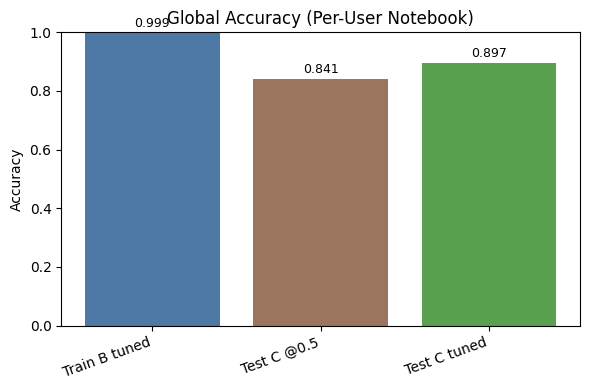

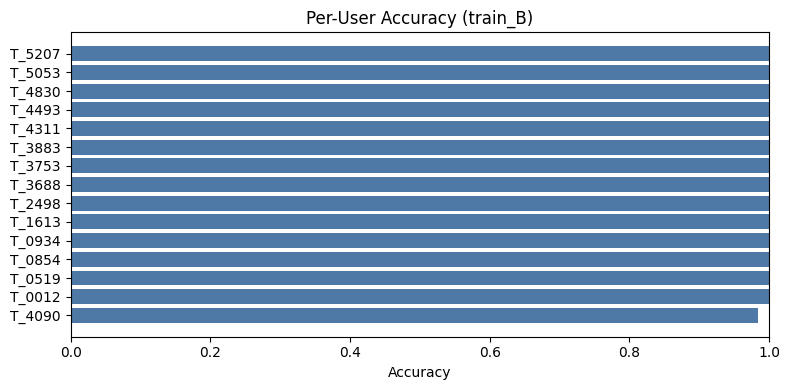

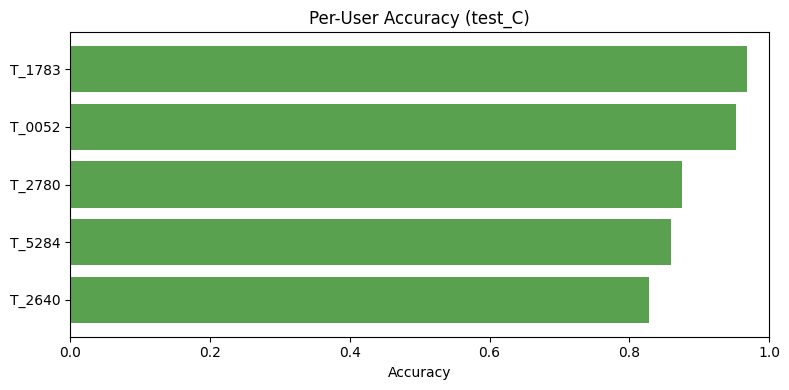

In [7]:
# Diagrams: global B/C accuracy and per-user accuracy
mB = results['metrics_B_tuned_threshold']; mC = results['metrics_C_tuned_threshold']; mC05 = results['metrics_C_default_threshold_0_5']
fig, ax = plt.subplots(figsize=(6,4))
labels = ['Train B tuned', 'Test C @0.5', 'Test C tuned']
vals = [mB['accuracy'], mC05['accuracy'], mC['accuracy']]
ax.bar(labels, vals, color=['#4e79a7','#9c755f','#59a14f'])
ax.set_ylim(0,1); ax.set_ylabel('Accuracy'); ax.set_title('Global Accuracy (Per-User Notebook)')
for i,v in enumerate(vals): ax.text(i, v+0.02, f'{v:.3f}', ha='center', fontsize=9)
plt.xticks(rotation=20, ha='right'); plt.tight_layout(); plt.show()

for split_name, color in [('train_B', '#4e79a7'), ('test_C', '#59a14f')]:
    g = per_user_df[per_user_df['split']==split_name].sort_values('accuracy')
    if g.empty: continue
    fig, ax = plt.subplots(figsize=(8,4))
    ax.barh(g['speaker_id'], g['accuracy'], color=color)
    ax.set_xlim(0,1); ax.set_xlabel('Accuracy'); ax.set_title(f'Per-User Accuracy ({split_name})')
    plt.tight_layout(); plt.show()


,split,group,speaker_id,n_samples,n_bonafide,n_spoof,accuracy,auc,bonafide_recall,spoof_recall,fp_bonafide_as_spoof,fn_spoof_as_bonafide
2,test_C,C,T_2640,64,32,32,0.828125,0.985352,0.65625,1.00000,11,0
4,test_C,C,T_5284,64,32,32,0.859375,1.000000,1.00000,0.71875,0,9
3,test_C,C,T_2780,64,32,32,0.875000,1.000000,1.00000,0.75000,0,8
0,test_C,C,T_0052,64,32,32,0.953125,0.993164,1.00000,0.90625,0,3
1,test_C,C,T_1783,64,32,32,0.968750,1.000000,0.93750,1.00000,2,0


Weakest test user: T_2640


,group,speaker_id,utt_id,label_str,label_id,system_id,split,prob_spoof,pred_label_id,pred_label_str
1088,C,T_2640,T_0000003949,bonafide,0,bonafide,test_C,0.835417,1,spoof
1089,C,T_2640,T_0000011900,bonafide,0,bonafide,test_C,0.628643,0,bonafide
1090,C,T_2640,T_0000013019,bonafide,0,bonafide,test_C,0.700063,0,bonafide
1091,C,T_2640,T_0000024946,bonafide,0,bonafide,test_C,0.942304,1,spoof
1092,C,T_2640,T_0000026973,bonafide,0,bonafide,test_C,0.560223,0,bonafide


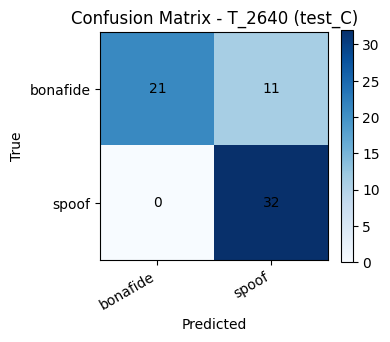

In [8]:
# Inspect weakest/strongest test users quickly
c_users = per_user_df[per_user_df['split']=='test_C'].sort_values('accuracy')
display(c_users)
if len(c_users):
    weak_spk = c_users.iloc[0]['speaker_id']
    g = pred_all[(pred_all['split']=='test_C') & (pred_all['speaker_id']==weak_spk)]
    print('Weakest test user:', weak_spk)
    display(g.head())
    cm = confusion_matrix(g['label_id'], g['pred_label_id']).tolist()
    plot_confmat(cm, f'Confusion Matrix - {weak_spk} (test_C)')
    plt.show()
